# Exploratory Data Analysis (EDA)

Now that I've have completed an initial cleaning of the data, it's time to explore what data we are looking at.
During my EDA, I will take a look at what data is missing and decide on how to deal with that. I will decide on my dependent variable, and explore its correlation to the features as well as correlations between the different features.

In [1]:
# importing packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Downloading cvs files
housing = pd.read_csv('../capstone2-housing/rawdata/cleaned_data.csv', index_col=0, parse_dates=['YrMoSold'])
data_dict = pd.read_csv('../capstone2-housing/documents/data_dictionary.csv', index_col=0)

All the rows in the data dictionary that have a value in column "Note" indicate categorical data in this data set. I will use the data dictionary to parse over my data set and change the dtype of those columns to objects.

In [3]:
# Creating list of columns that should have categorical dtype
dtype_object = ['Id']
for index, row in data_dict.iterrows():
    if pd.notnull(row[2]):
        dtype_object.append(row[0])

# Casting correct dtypes for categorical data columns and creating new df for cleaned housing data
housing_dtypes_clean = housing[dtype_object].astype('object')
housing = housing.merge(housing).drop_duplicates(keep='first').reset_index(drop=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             1460 non-null   int64         
 1   MSSubClass     1460 non-null   int64         
 2   MSZoning       1460 non-null   object        
 3   LotFrontage    1201 non-null   float64       
 4   LotArea        1460 non-null   int64         
 5   Street         1460 non-null   object        
 6   Alley          91 non-null     object        
 7   LotShape       1460 non-null   object        
 8   LandContour    1460 non-null   object        
 9   Utilities      1460 non-null   object        
 10  LotConfig      1460 non-null   object        
 11  LandSlope      1460 non-null   object        
 12  Neighborhood   1460 non-null   object        
 13  Condition1     1460 non-null   object        
 14  Condition2     1460 non-null   object        
 15  BldgType       1460 n

Now, let's start with deciding on a dependent variable. Since all final closing prices are available, and my goal with this project is to build a model to predict final closing prices, I will start with considering using the column SalePrice as the dependent variable. Let's take a closer look at the column.

In [4]:
housing['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

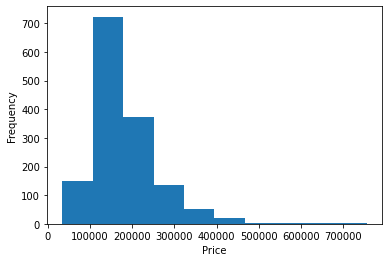

In [5]:
_ = plt.hist(housing['SalePrice'])
_ = plt.xlabel("Price")
_ = plt.ylabel("Frequency")

Looks like the final SalePrice in Iowa is a continuous value that ranges between 34900 and 755000. Has a mean of 180921.2 and a standard deviation of 79442.5. So I will be moving forward with SalePrice as my dependent variable.  
Have the final sale prices varied a lot over the years?

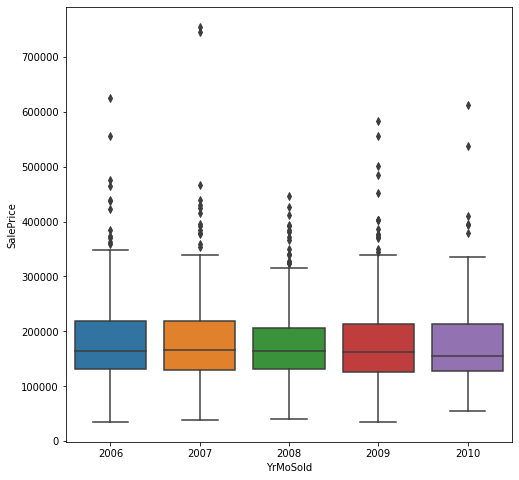

In [6]:
year_sold = housing['YrMoSold'].dt.year
_ = plt.figure(figsize=(8,8))
_ = sns.boxplot(x=year_sold, y='SalePrice', data=housing)

Seems like they have approximately same average value throughout the past year XXXXXGET BOXPLOT LABELSXXXXX 
  
So I will be working with sale prices but before we move on let's take a look at the missing values I identified during Data Wrangling and decide what to do with them.

In [7]:
# Count and percentage of missing data in columns
missing = pd.concat([housing.isnull().sum(), 100 * housing.isnull().mean().round(4)], axis=1)
missing.columns=['count', '%']
missing_values = missing.sort_values(by=['count', '%'], ascending=False)
cols_missing = missing_values.loc[missing_values['count'] != 0.00]
cols_missing

,count,%
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


First, I want to know: what are missing values in this data set? Does NaN mean missing as in incomplete or missing as in property not having the feature. Let's take a look at my data dictionary to see what NaN means for given object dtype columns.

In [8]:
for name in cols_missing.index:
    data_name = data_dict[data_dict['Name'] == name].iloc[0]
    print(data_name['Name'],':', data_name['Notes'], '\n')

PoolQC :        Ex:Excellent       Gd:Good       TA:Average/Typical       Fa:Fair       NA:No Pool 

MiscFeature :        Elev:Elevator       Gar2:2nd Garage (if not described in garage section)       Othr:Other       Shed:Shed (over 100 SF)       TenC:Tennis Court       NA:None 

Alley :        Grvl:Gravel       Pave:Paved       NA :No alley access 

Fence :        GdPrv:Good Privacy       MnPrv:Minimum Privacy       GdWo:Good Wood       MnWw:Minimum Wood/Wire       NA:No Fence 

FireplaceQu :        Ex:Excellent - Exceptional Masonry Fireplace       Gd:Good - Masonry Fireplace in main level       TA:Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement       Fa:Fair - Prefabricated Fireplace in basement       Po:Poor - Ben Franklin Stove       NA:No Fireplace 

LotFrontage : nan 

GarageType :        2Types:More than one type of garage       Attchd:Attached to home       Basment:Basement Garage       BuiltIn:Built-In (Garage part of house - typically 

Looking at the data_dictionary, I can conclude that NaN values in columns with categorical dtypes imply that the property doesn't have that feature. And I will leave those "missing values" as is. But what about the missing values that aren't categorical (GarageYrBlt, LotFrontage and MasVnrArea)?
Let's take a look at them:

In [9]:
housing[['GarageYrBlt', 'LotFrontage', 'MasVnrArea']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GarageYrBlt  1379 non-null   float64
 1   LotFrontage  1201 non-null   float64
 2   MasVnrArea   1452 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [10]:
# including MasVnrType for sanity check (MasVnrType None for MasVnrArea 0.0)
housing[['GarageYrBlt', 'LotFrontage', 'MasVnrType', 'MasVnrArea']].head()

,GarageYrBlt,LotFrontage,MasVnrType,MasVnrArea
0,2003.0,65.0,BrkFace,196.0
1,1976.0,80.0,None,0.0
2,2001.0,68.0,BrkFace,162.0
3,1998.0,60.0,None,0.0
4,2000.0,84.0,BrkFace,350.0


Based on MasVnrType and MasVnrArea, I can fairly safely assume that missing values in MasVnrArea means that the properties don't have Masonry veneers.
Now, LotFrontage has 17.74% missing values, let's take a look at how lot frontage correlates to SalePrices

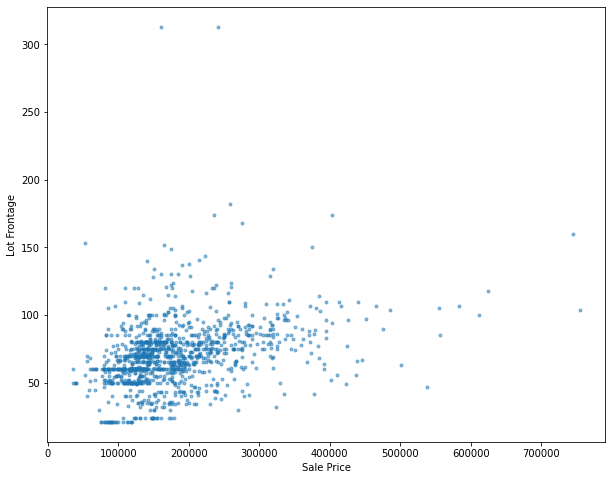

In [11]:
_ = plt.figure(figsize=(10,8))
_ = plt.plot('SalePrice', 'LotFrontage', '.', data=housing, alpha=0.5)
_ = plt.xlabel('Sale Price')
_ = plt.ylabel('Lot Frontage')

And how does LotFrontage correlate to the other features? Let's create a heatmap to compare correlations between all numerical features:

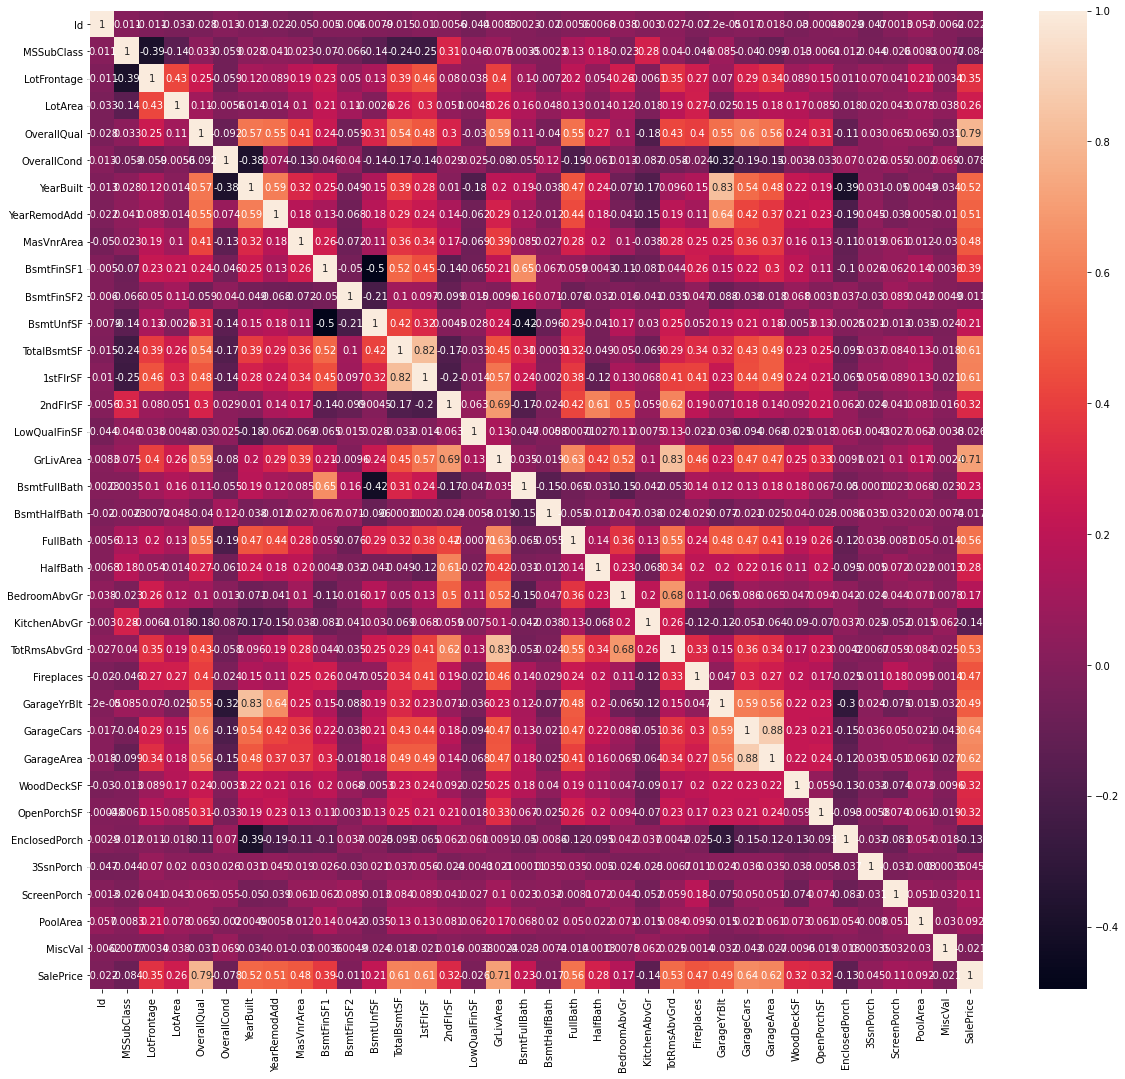

In [15]:
_ = plt.figure(figsize=(20,18))
_ = sns.heatmap(housing.corr(), annot=True)

SalePrice and Lot frontage only have a very low positive correlation (0.35)  
Some moderate positive correlations are OverallQual (0.79), GrLivArea (0.71), and GarageCars (0.64)

Some moderately strong positive correlations between the other features include: 
1. GarageYrBlt and YearBuilt (0.83)
2. GarageCars and GarageArea (fairly obvious, 0.88)
3. TotRmsAbvGrd and GrLivArea (0.83)